In [1]:
import numpy as np
import pandas as pd
import seaborn

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from commute_times.utils import (
    random_uniform_ellipse,
    sample_gamma,
    in_first_quad, in_second_quad, in_third_quad, in_fourth_quad,
    compute_raw_distance)
from commute_times.commute_times import (
    CommuteTimeData,
    compute_time_of_day_factor,
    sample_time_of_day,
    sample_commute_time,
    sample_commute_type,
    compute_commute_type_factor
)

In [3]:
N = 5000

In [4]:
commute_data = CommuteTimeData().sample(5000)
commute_data['log_commute_time'] = np.log(commute_data['commute_time'])

In [5]:
commute_data.head()

,source_latitude,source_longitude,destination_latitude,destination_longitude,time_of_day_ts,commute_type,commute_time,log_commute_time
0,-0.964033,0.185712,-0.718515,0.284121,2018-08-13 19:38:00,CAR,6.361716,1.850298
1,-0.794619,0.342886,0.503648,0.146980,2018-08-13 08:51:00,CAR,18.446673,2.914884
2,0.484381,0.707004,0.325769,-0.874017,2018-08-13 08:57:00,TRAIN,12.231557,2.504019
3,0.392657,0.275814,-0.095796,0.743344,2018-08-13 17:58:00,CAR,18.018945,2.891424
4,-0.328260,-0.132220,-0.686195,0.144206,2018-08-13 17:19:00,BUS,21.119813,3.050212


In [6]:
sources = np.column_stack([
    commute_data['source_latitude'], commute_data['source_longitude']])
targets = np.column_stack([
    commute_data['destination_latitude'], commute_data['destination_longitude']])

time_of_day_ts = commute_data['time_of_day_ts']
time_of_day = time_of_day_ts.dt.hour + (1/60)*time_of_day_ts.dt.minute
commute_data['time_of_day'] = time_of_day

commute_type = commute_data['commute_type']
commute_time = commute_data['commute_time']

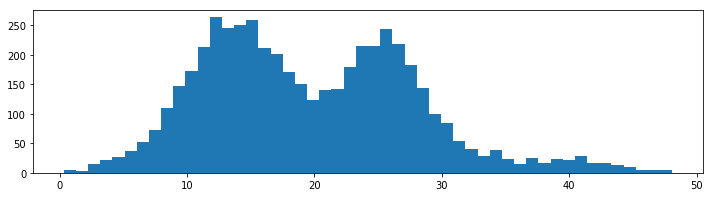

In [7]:
fig, ax = plt.subplots(figsize=(12, 3))
_ = ax.hist(commute_time, bins=50)

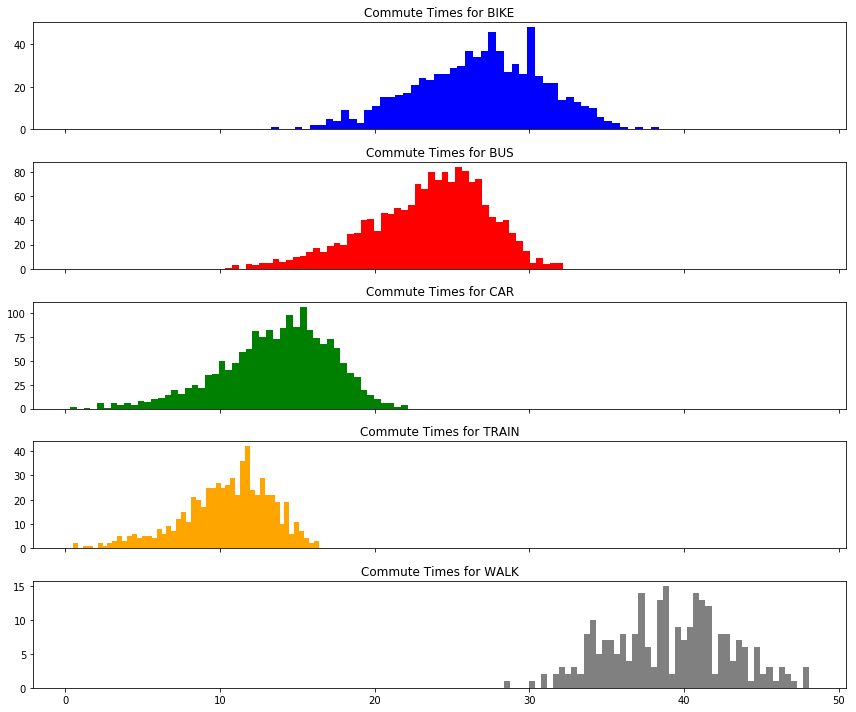

In [8]:
fig, axs = plt.subplots(5, 1, figsize=(12, 10), sharex=True)
colors = ['blue', 'red', 'green', 'orange', 'grey']

for ax, ctype, color in zip(axs, np.unique(commute_type), colors):
    ctime = commute_time[commute_type == ctype]
    ax.hist(ctime, bins=50, color=color)
    ax.set_title(f"Commute Times for {ctype}")
fig.tight_layout()

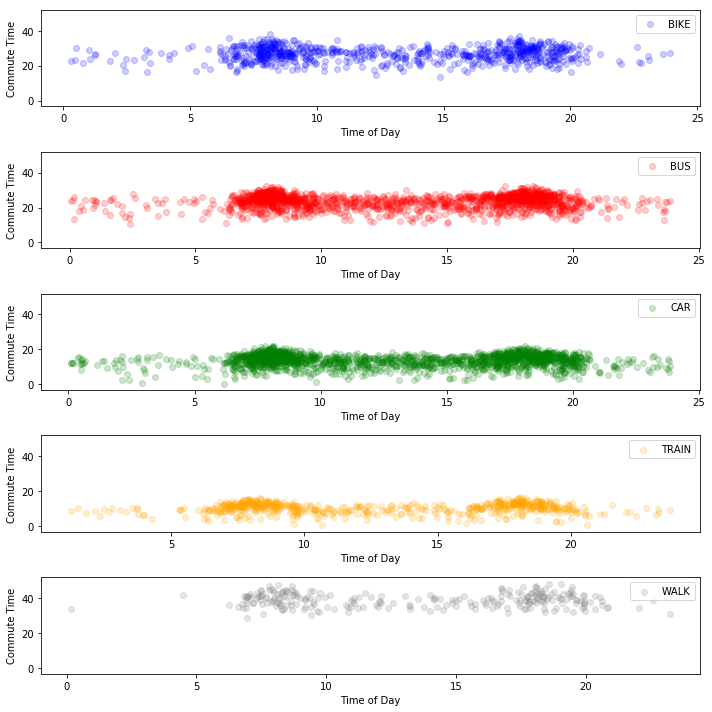

In [9]:
fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharey=True)
colors = ['blue', 'red', 'green', 'orange', 'grey']

for ax, ctype, color in zip(axs, np.unique(commute_type), colors):
    tod = time_of_day[commute_type == ctype]
    ctime = commute_time[commute_type == ctype]
    ax.scatter(tod, ctime, alpha=0.2, color=color, label=ctype)
    ax.set_xlabel("Time of Day")
    ax.set_ylabel("Commute Time")
    ax.legend()
fig.tight_layout()

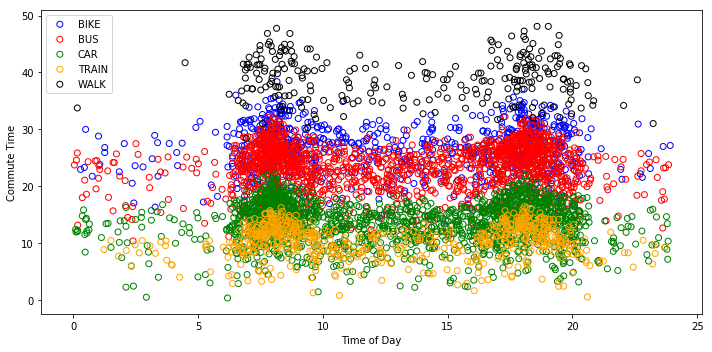

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['blue', 'red', 'green', 'orange', 'black']

for ctype, color in zip(np.unique(commute_type), colors):
    tod = time_of_day[commute_type == ctype]
    ctime = commute_time[commute_type == ctype]
    ax.scatter(tod, ctime, alpha=1.0, color=color, label=ctype,   
               facecolors='none',
               edgecolors=color)
    ax.set_xlabel("Time of Day")
    ax.set_ylabel("Commute Time")
    ax.legend()
fig.tight_layout()

In [11]:
d = compute_raw_distance(sources, targets)

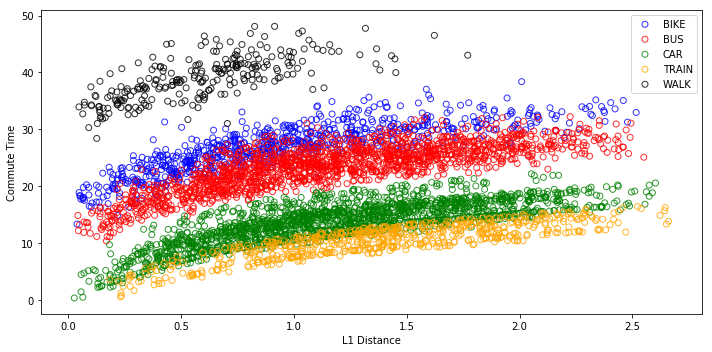

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))

for ctype, color in zip(np.unique(commute_type), colors):
    dist = d[commute_type == ctype]
    ctime = commute_time[commute_type == ctype]
    ax.scatter(dist, ctime, alpha=0.8, color=color, label=ctype,   
               facecolors='none',
               edgecolors=color)
    ax.set_xlabel("L1 Distance")
    ax.set_ylabel("Commute Time")
    ax.legend()
fig.tight_layout()

In [14]:
# Calculate conjestion
commute_data['hour_of_day'] = commute_data['time_of_day'].apply(np.floor)
conjestion_by_hour = commute_data.groupby('hour_of_day').size()

In [15]:
commute_data = pd.merge(
             left=commute_data, 
             right=pd.DataFrame(conjestion_by_hour, columns=["conjestion"]), 
             left_on='hour_of_day', 
             right_on=conjestion_by_hour.index)

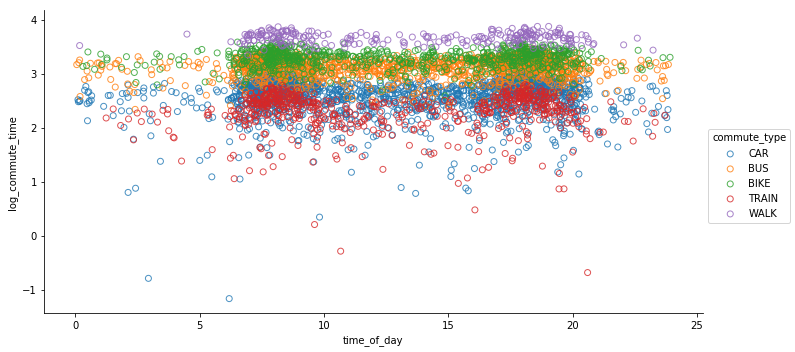

In [16]:
fg = seaborn.FacetGrid(data=commute_data, hue='commute_type', size=5, aspect=2)
fg.map(plt.scatter, 'time_of_day', 'log_commute_time', alpha=0.8, facecolors='none').add_legend()

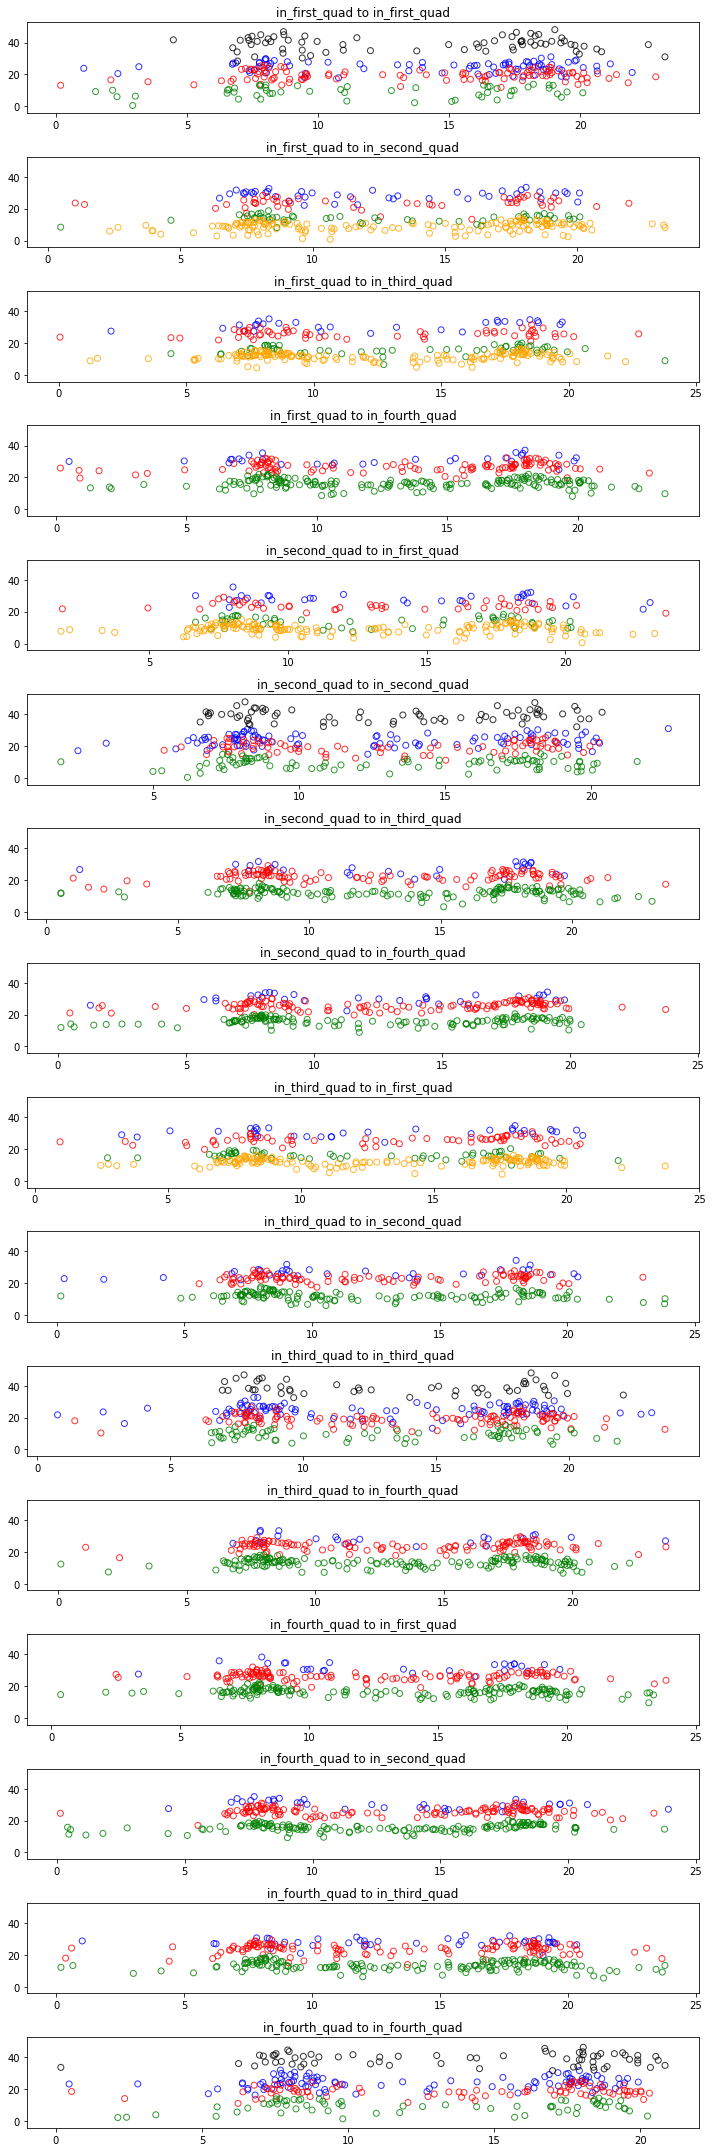

In [17]:
from itertools import product

quad_indicators = [
    in_first_quad, in_second_quad, in_third_quad, in_fourth_quad]

fig, axs = plt.subplots(4*4, 1, figsize=(10, 30), sharey=True)
for (source_quad_mask, target_quad_mask), ax in zip(
        product(quad_indicators, quad_indicators), axs.flatten()):
    quad_mask = source_quad_mask(sources) & target_quad_mask(targets)
    for ctype, color in zip(np.unique(commute_type), colors):
        commute_type_mask = commute_type == ctype
        ax.scatter(
            time_of_day[quad_mask & commute_type_mask], 
            commute_time[quad_mask & commute_type_mask],
            alpha=0.8,
            facecolors='none',
            edgecolors=color)
        ax.set_title(f"{source_quad_mask.__name__} to {target_quad_mask.__name__}")
fig.tight_layout()